In [3]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn

images = np.load("../images.npy")
labels = np.load("../labels.npy")

input_labels = (labels > 0).astype(dtype=np.float)
images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))
images = images.astype(dtype=np.float)
images = images/255

train_images = torch.Tensor(images[0:40000, : ])
cv_images = torch.Tensor(images[40000:45000, : ])
test_images = torch.Tensor(images[45000:50000, :])

#split the labels in to train, validation and test data
train_labels = torch.FloatTensor(input_labels[0:40000])
cv_labels = torch.FloatTensor(input_labels[40000:45000])
test_labels = torch .FloatTensor(input_labels[45000:50000])

In [9]:
def accuracy(y,y_hat):
    count = 0;
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

def accuracy_random_train():

    import random
    import numpy as np


    x =random.sample(range(0,40000),1000)
    y = np.empty(1000)
    y_hat = np.empty(1000)


    index=0
    #print(w1)
    
    for i in x:

        images_random = Variable(train_images[i].view(1,676), requires_grad=False)
        y[index] = train_labels[i]

        y_pred = torch.sigmoid(images_random.mm(w1).clamp(0).mm(w2))
        #y_pred = torch.sigmoid(a.mm(w1).clamp(0).mm(w2))
        
        

        res = y_pred.data[0][0]
    

        if res <= 0.5:
            act_label = 0
        else:
            act_label = 1

        y_hat[index] = act_label
        index += 1

    acc = accuracy(y,y_hat)
   
  
    return acc


    

def accuracy_random_validation():

    import random
    import numpy as np


    x =random.sample(range(0,5000),1000)
    y = np.empty(1000)
    y_hat = np.empty(1000)


    index=0
    
    for i in x:

        images_random = Variable(cv_images[i].view(1,676), requires_grad=False)
        y[index] = cv_labels[i]

       
        y_pred = torch.sigmoid(images_random.mm(w1).clamp(0).mm(w2))


        res = y_pred.data[0][0]
    

        if res <= 0.5:
            act_label = 0
        else:
            act_label = 1

        y_hat[index] = act_label
        index += 1

    acc = accuracy(y,y_hat)
  
    return acc



In [42]:
dtype = torch.FloatTensor

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 676, 100, 1
online_training_iterations = 4
input_size = 40000
size = (online_training_iterations * input_size) / 100
index = 0

# N dimensional arrays to store training and validation accuracies for every 100 steps
accuracy_train = []
accuracy_valid = []
w1 = Variable(torch.randn(D_in, H).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H, D_out).type(dtype), requires_grad=True)

w1.data = torch.div(w1.data, 100)
w2.data = torch.div(w2.data, 100)
learning_rate = 0.001
for i in range(online_training_iterations):
    for t in range(40000):

        x = Variable(train_images[t].view(1,676), requires_grad=False)

        y = train_labels[t]
        
        
        y_pred = torch.sigmoid(x.mm(w1).clamp(min = 0).mm(w2))#.clamp(min= 0.001, max= 0.999))
        
        loss = -(y * torch.log(y_pred) + 
                 (1-y) * torch.log(1 - y_pred)) 
        
        if t%100 == 0:
            accuracy_train.append(accuracy_random_train())
            accuracy_valid.append(accuracy_random_validation())

        loss.backward()
        w1.data -= learning_rate * w1.grad.data
        w2.data -= learning_rate * w2.grad.data
        
        w1.data = w1.data/torch.norm(w1.data)
        w2.data = w2.data/torch.norm(w2.data)

        w1.grad.data.zero_()
        w2.grad.data.zero_() 
print(w1)
#print(max(accuracy_random_train))
#print(max(accuracy_random_validation))

Variable containing:
-9.1274e-08  4.3806e-08  2.6714e-07  ...   2.0420e-07 -3.5225e-09  9.2208e-07
-1.6657e-06  7.9381e-07  4.8408e-06  ...   3.7004e-06 -6.4323e-08  1.6709e-05
-1.2442e-06  1.1793e-06  7.1919e-06  ...   5.4976e-06 -4.8048e-08  2.4824e-05
                ...                   ⋱                   ...                
 2.2022e-06 -1.1529e-06 -7.0304e-06  ...  -5.3741e-06  8.5043e-08 -2.4267e-05
 2.0218e-06 -8.9408e-07 -5.4523e-06  ...  -4.1678e-06  7.8076e-08 -1.8820e-05
 6.8494e-08 -3.0527e-08 -1.8616e-07  ...  -1.4230e-07  2.6447e-09 -6.4255e-07
[torch.FloatTensor of size 676x100]



0.967
0.97


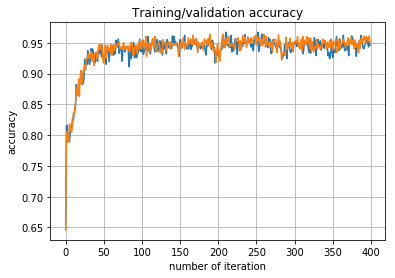

In [43]:
import matplotlib.pyplot as plt


t = np.arange(0,400,1)

s = accuracy_train[0:400]
k = accuracy_valid[0:400]
print(max(accuracy_train))
print(max(accuracy_valid))
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

In [99]:
#Testing on kaggle data set.
#Generate a csv file with predictions.

#load the test data.

test_data = np.load("./test_images.npy")
#images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1]*test_data.shape[2]))

#normalise the data.
test_data = test_data/100
#create a csv file and add the first line.
#print(test_data.shape[0])
output = np.empty((5000, 2), dtype=np.uint0)
for i in range(test_data.shape[0]):
    x = Variable(torch.Tensor(test_data[i]).view(1,676), requires_grad = False)
    label = torch.sigmoid(x.mm(w1).clamp(min=0).mm(w2))
    res = label.data[0][0]
    if res <= 0.5:
        true_label = 0
    else: 
        true_label = 1
    output[i] = [i, true_label]

np.savetxt('out.csv', output, delimiter=",",fmt='%1.0f', header="id,label")

    
"""
arr = np.array([[1,2], [3,4]])
print(arr[0]) 
arr[0] = [6, 7]
print(arr[0])
"""

'\narr = np.array([[1,2], [3,4]])\nprint(arr[0]) \narr[0] = [6, 7]\nprint(arr[0])\n'

# Is this Overfitting:

From the plot above, there is no over fitting. The accuracies of training and cross validation data sets differ only by 1 percentage points

Kaggle submission username : villa1